# Tuning and Optimizing Neural Networks - Lab

## Introduction

Now that we've discussed some regularization, initialization and optimization techniques, its time to synthesize those concepts into a cohesive modelling pipeline.  

With this pipeline, yoiu will not only fit an initial model but will also attempt to set various hyperparameters for regularization techniques. Your final model selection will pertain to the test metrics across these models. This will more naturally simulate a problem you might be faced with in practice, and the various modelling decisions you are apt to encounter along the way.  

Recall that our end objective is to achieve a balance between overfitting and underfitting. We've discussed the bias variance tradeoff, and the role of regularization in order to reduce overfitting on training data and improving generalization to new cases. Common frameworks for such a procedure include train/validate/test methodology when data is plentiful, and K-folds cross-validation for smaller, more limited datasets. In this lab, you'll perform the latter, as the dataset in question is fairly limited. 

## Objectives

You will be able to:

* Implement a K-folds cross validation modelling pipeline
* Apply normalization as a preprocessing technique
* Apply regularization techniques to improve your model's generalization
* Choose an appropriate optimization strategy 

## Loading the Data

In [23]:
import pandas as pd
import numpy as np

In [24]:
#Your code here; load and preview the dataset
data = pd.read_csv('loan_final.csv')
data.head()

,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,total_acc,total_pymnt,application_type
0,5000.0,4975.0,36 months,10.65%,162.87,B,10+ years,RENT,24000.0,Verified,Fully Paid,credit_card,AZ,9.0,5863.155187,Individual
1,2500.0,2500.0,60 months,15.27%,59.83,C,< 1 year,RENT,30000.0,Source Verified,Charged Off,car,GA,4.0,1014.530000,Individual
2,2400.0,2400.0,36 months,15.96%,84.33,C,10+ years,RENT,12252.0,Not Verified,Fully Paid,small_business,IL,10.0,3005.666844,Individual
3,10000.0,10000.0,36 months,13.49%,339.31,C,10+ years,RENT,49200.0,Source Verified,Fully Paid,other,CA,37.0,12231.890000,Individual
4,3000.0,3000.0,60 months,12.69%,67.79,B,1 year,RENT,80000.0,Source Verified,Fully Paid,other,OR,38.0,4066.908161,Individual


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42538 entries, 0 to 42537
Data columns (total 16 columns):
loan_amnt              42535 non-null float64
funded_amnt_inv        42535 non-null float64
term                   42535 non-null object
int_rate               42535 non-null object
installment            42535 non-null float64
grade                  42535 non-null object
emp_length             41423 non-null object
home_ownership         42535 non-null object
annual_inc             42531 non-null float64
verification_status    42535 non-null object
loan_status            42535 non-null object
purpose                42535 non-null object
addr_state             42535 non-null object
total_acc              42506 non-null float64
total_pymnt            42535 non-null float64
application_type       42535 non-null object
dtypes: float64(6), object(10)
memory usage: 5.2+ MB


In [26]:
data.isna().sum()

loan_amnt                 3
funded_amnt_inv           3
term                      3
int_rate                  3
installment               3
grade                     3
emp_length             1115
home_ownership            3
annual_inc                7
verification_status       3
loan_status               3
purpose                   3
addr_state                3
total_acc                32
total_pymnt               3
application_type          3
dtype: int64

In [27]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41394 entries, 0 to 42516
Data columns (total 16 columns):
loan_amnt              41394 non-null float64
funded_amnt_inv        41394 non-null float64
term                   41394 non-null object
int_rate               41394 non-null object
installment            41394 non-null float64
grade                  41394 non-null object
emp_length             41394 non-null object
home_ownership         41394 non-null object
annual_inc             41394 non-null float64
verification_status    41394 non-null object
loan_status            41394 non-null object
purpose                41394 non-null object
addr_state             41394 non-null object
total_acc              41394 non-null float64
total_pymnt            41394 non-null float64
application_type       41394 non-null object
dtypes: float64(6), object(10)
memory usage: 5.4+ MB


## Defining the Problem

Set up the problem by defining X and Y. 

For this problem use the following variables for X:
* loan_amnt
* home_ownership
* funded_amnt_inv
* verification_status
* emp_length
* installment
* annual_inc

Be sure to use dummy variables for categorical variables and to normalize numerical quanitities. Be sure to also remove any rows with null data.  

For Y, we are looking to build a model to predict the total payment received for a loan.

In [28]:
# Your code here; appropriately define X and Y using dummy variables and normalization for preprocessing.
X0 = data["loan_amnt"]
X1 = data["funded_amnt_inv"]
X2 = data["installment"]
X3 = data["annual_inc"]

X0 = (X0-X0.mean()) / X0.std()
X1 = (X1-X1.mean()) / X1.std()
X2 = (X2-X2.mean()) / X2.std()
X3 = (X3-X3.mean()) / X3.std()

dummy_home = pd.get_dummies(data['home_ownership'])
dummy_ver = pd.get_dummies(data['verification_status'])
dummy_emp = pd.get_dummies(data['emp_length'])

X = pd.concat([X0, X1, X2, X3, dummy_home, dummy_ver, dummy_emp], axis=1)
y = data['total_pymnt']
y = (y-y.mean()) / y.std()

In [29]:
X.shape, y.shape

((41394, 23), (41394,))

## Generating a Hold Out Test Set

While we will be using K-fold cross validation to select an optimal model, we still want a final hold out test set that is completely independent of any modelling decisions. As such, pull out a sample of 10% of the total available data. For consistency of results, use random seed 123. 

In [30]:
# Your code here; generate a hold out test set for final model evaluation. Use random seed 123.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

In [31]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.head()

(37254, 23) (4140, 23) (37254,) (4140,)


,loan_amnt,funded_amnt_inv,installment,annual_inc,MORTGAGE,NONE,OTHER,OWN,RENT,Not Verified,...,10+ years,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,< 1 year
24882,0.112847,0.021326,-0.286456,0.189658,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5723,-0.669243,-0.559684,-0.587670,-0.151156,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
32465,0.841000,1.008344,1.374306,0.468506,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
34510,-0.831054,-0.727687,-0.806899,-0.306071,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
9396,0.921906,1.092346,1.162820,0.158675,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


## Defining a K-fold Cross Validation Methodology

Now that your have a complete holdout test set, write a function that takes in the remaining data and performs k-folds cross validation given a model object. Be sure your function returns performance metrics regarding the training and validation sets.

In [32]:
#Your code here; define a function to evaluate a model object using K folds cross validation.


from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def k_folds(features_train, labels_train, model_obj, k=10, n_epochs=100):
    colors = sns.color_palette("Set2")

    validation_scores = [] 
    
    kf = KFold(n_splits=10, shuffle=True)
    
    fig, axes = plt.subplots(2, 5, figsize=(12,8))
    for i, (train_index, test_index) in enumerate(kf.split(features_train)):
        "Currently graph imaging assumes 10 folds and is hardcoded to 5x2 layout."
        row = i//5
        col = i%5
        X_train, X_val = features_train.iloc[train_index], features_train.iloc[test_index]
        y_train, y_val = labels_train.iloc[train_index], labels_train.iloc[test_index]
        
        model = model_obj
        hist = model.fit(X_train, y_train, batch_size=32,
                         epochs=n_epochs, verbose=1, validation_data = (X_val, y_val))
        #Note: verboxe=0 turns off printouts regarding training for each epoch.
        #Potential simpler methodology
        validation_score = model.evaluate(X_val, y_val)
        validation_scores.append(validation_score)
        ax = axes[row, col]
        k = 'val_loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[0])

        k = 'loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[1])
        ax.set_title('Fold {} Validation'.format(i+1))
    #Final Graph Formatting
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    plt.legend(bbox_to_anchor=(1,1))
    
    #General Overview
    validation_score = np.average(validation_scores)
    print('Mean Validation Score:', validation_score)
    print('Standard Deviation of Validation Scores:', np.std(validation_scores))
    return validation_score

## Building a Baseline Model

Here, it is also important to define your evaluation metric that you will look to optimize while tuning the model.   

In general, model training to optimize this metric may consist of using a validation and test set if data is plentiful, or k-folds cross-validation if data is limited. We set up a k-folds cross-validation for this task since the dataset is not overly large.  

Build an initial sequential model with 2 hidden relu layers. The first should have 7 hidden units, and the second 10 hidden units. Finally, add a third layer with a linear activation function to output our predictions for the total loan payment. 

In [33]:
#Your code here; define and compile an initial model as described
from keras.models import Sequential
from keras.layers import Dense

model=Sequential()

model.add(Dense(units=7, input_dim=23, activation="relu", kernel_initializer="normal"))
model.add(Dense(units=10, activation="relu"))
model.add(Dense(units=1, kernel_initializer='normal', activation='linear'))

model.compile(optimizer="sgd", loss="mse", metrics=["mse"])


## Evaluating the Baseline Model with K-Folds Cross Validation

Use your k-folds function to evaluate the baseline model.  

Note: This code block is likely to take 10-20 minutes to run depending on the specs on your computer.
Because of time dependencies, it can be interesting to begin timing these operations for future reference.

Here's a simple little recipe to achieve this:
```
import time
import datetime

now = datetime.datetime.now()
later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)
```

Train on 33528 samples, validate on 3726 samples
Epoch 1/100
33528/33528 [==============================] - 3s 84us/step - loss: 0.5130 - mean_squared_error: 0.5130 - val_loss: 0.2560 - val_mean_squared_error: 0.2560
Epoch 2/100
33528/33528 [==============================] - 2s 70us/step - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2273 - val_mean_squared_error: 0.2273
Epoch 3/100
33528/33528 [==============================] - 2s 68us/step - loss: 0.1951 - mean_squared_error: 0.1951 - val_loss: 0.2245 - val_mean_squared_error: 0.2245
Epoch 4/100
33528/33528 [==============================] - 3s 77us/step - loss: 0.1934 - mean_squared_error: 0.1934 - val_loss: 0.2226 - val_mean_squared_error: 0.2226
Epoch 5/100
33528/33528 [==============================] - 3s 75us/step - loss: 0.1958 - mean_squared_error: 0.1958 - val_loss: 0.2250 - val_mean_squared_error: 0.2250
Epoch 6/100
33528/33528 [==============================] - 3s 79us/step - loss: 0.1915 - mean_squared_error: 0.

33528/33528 [==============================] - 3s 75us/step - loss: 0.1826 - mean_squared_error: 0.1826 - val_loss: 0.2191 - val_mean_squared_error: 0.2191
Epoch 50/100
33528/33528 [==============================] - 3s 75us/step - loss: 0.1826 - mean_squared_error: 0.1826 - val_loss: 0.2156 - val_mean_squared_error: 0.2156
Epoch 51/100
33528/33528 [==============================] - 2s 73us/step - loss: 0.1825 - mean_squared_error: 0.1825 - val_loss: 0.2174 - val_mean_squared_error: 0.2174
Epoch 52/100
33528/33528 [==============================] - 3s 76us/step - loss: 0.1830 - mean_squared_error: 0.1830 - val_loss: 0.2213 - val_mean_squared_error: 0.2213
Epoch 53/100
33528/33528 [==============================] - 3s 77us/step - loss: 0.1829 - mean_squared_error: 0.1829 - val_loss: 0.2170 - val_mean_squared_error: 0.2170
Epoch 54/100
33528/33528 [==============================] - 3s 78us/step - loss: 0.1826 - mean_squared_error: 0.1826 - val_loss: 0.2171 - val_mean_squared_error: 0.2171

33528/33528 [==============================] - 2s 71us/step - loss: 0.1818 - mean_squared_error: 0.1818 - val_loss: 0.2179 - val_mean_squared_error: 0.2179
Epoch 98/100
33528/33528 [==============================] - 2s 66us/step - loss: 0.1817 - mean_squared_error: 0.1817 - val_loss: 0.2154 - val_mean_squared_error: 0.2154
Epoch 99/100
33528/33528 [==============================] - 2s 68us/step - loss: 0.1816 - mean_squared_error: 0.1816 - val_loss: 0.2187 - val_mean_squared_error: 0.2187
Epoch 100/100
3726/3726 [==============================] - 0s 31us/step
Train on 33528 samples, validate on 3726 samples
Epoch 1/100
33528/33528 [==============================] - 2s 64us/step - loss: 0.1842 - mean_squared_error: 0.1842 - val_loss: 0.1932 - val_mean_squared_error: 0.1932
Epoch 2/100
33528/33528 [==============================] - 2s 67us/step - loss: 0.1843 - mean_squared_error: 0.1843 - val_loss: 0.1932 - val_mean_squared_error: 0.1932
Epoch 3/100
33528/33528 [========================

Epoch 45/100
33528/33528 [==============================] - 2s 70us/step - loss: 0.1832 - mean_squared_error: 0.1832 - val_loss: 0.1952 - val_mean_squared_error: 0.1952
Epoch 46/100
33528/33528 [==============================] - 2s 71us/step - loss: 0.1835 - mean_squared_error: 0.1835 - val_loss: 0.1962 - val_mean_squared_error: 0.1962
Epoch 47/100
33528/33528 [==============================] - 2s 70us/step - loss: 0.1835 - mean_squared_error: 0.1835 - val_loss: 0.1943 - val_mean_squared_error: 0.1943
Epoch 48/100
33528/33528 [==============================] - 2s 69us/step - loss: 0.1835 - mean_squared_error: 0.1835 - val_loss: 0.1992 - val_mean_squared_error: 0.1992
Epoch 49/100
33528/33528 [==============================] - 2s 68us/step - loss: 0.1833 - mean_squared_error: 0.1833 - val_loss: 0.1953 - val_mean_squared_error: 0.1953
Epoch 50/100
33528/33528 [==============================] - 2s 72us/step - loss: 0.1834 - mean_squared_error: 0.1834 - val_loss: 0.1955 - val_mean_squared_

33528/33528 [==============================] - 2s 75us/step - loss: 0.1828 - mean_squared_error: 0.1828 - val_loss: 0.1959 - val_mean_squared_error: 0.1959
Epoch 94/100
33528/33528 [==============================] - 2s 72us/step - loss: 0.1828 - mean_squared_error: 0.1828 - val_loss: 0.1959 - val_mean_squared_error: 0.1959
Epoch 95/100
33528/33528 [==============================] - 3s 76us/step - loss: 0.1829 - mean_squared_error: 0.1829 - val_loss: 0.1965 - val_mean_squared_error: 0.1965
Epoch 96/100
33528/33528 [==============================] - 2s 73us/step - loss: 0.1826 - mean_squared_error: 0.1826 - val_loss: 0.1957 - val_mean_squared_error: 0.1957
Epoch 97/100
33528/33528 [==============================] - 2s 70us/step - loss: 0.1830 - mean_squared_error: 0.1830 - val_loss: 0.1953 - val_mean_squared_error: 0.1953
Epoch 98/100
33528/33528 [==============================] - 2s 70us/step - loss: 0.1840 - mean_squared_error: 0.1840 - val_loss: 0.1968 - val_mean_squared_error: 0.1968

Epoch 41/100
33528/33528 [==============================] - 2s 70us/step - loss: 0.1850 - mean_squared_error: 0.1850 - val_loss: 0.1766 - val_mean_squared_error: 0.1766
Epoch 42/100
33528/33528 [==============================] - 2s 70us/step - loss: 0.1850 - mean_squared_error: 0.1850 - val_loss: 0.1742 - val_mean_squared_error: 0.1742
Epoch 43/100
33528/33528 [==============================] - 2s 71us/step - loss: 0.1853 - mean_squared_error: 0.1853 - val_loss: 0.1729 - val_mean_squared_error: 0.1729
Epoch 44/100
33528/33528 [==============================] - 3s 75us/step - loss: 0.1851 - mean_squared_error: 0.1851 - val_loss: 0.1749 - val_mean_squared_error: 0.1749
Epoch 45/100
33528/33528 [==============================] - 2s 68us/step - loss: 0.1852 - mean_squared_error: 0.1852 - val_loss: 0.1740 - val_mean_squared_error: 0.1740
Epoch 46/100
33528/33528 [==============================] - 2s 69us/step - loss: 0.1853 - mean_squared_error: 0.1853 - val_loss: 0.1746 - val_mean_squared_

33528/33528 [==============================] - 2s 67us/step - loss: 0.1848 - mean_squared_error: 0.1848 - val_loss: 0.1746 - val_mean_squared_error: 0.1746
Epoch 90/100
33528/33528 [==============================] - 2s 72us/step - loss: 0.1849 - mean_squared_error: 0.1849 - val_loss: 0.1762 - val_mean_squared_error: 0.1762
Epoch 91/100
33528/33528 [==============================] - 3s 77us/step - loss: 0.1852 - mean_squared_error: 0.1852 - val_loss: 0.1741 - val_mean_squared_error: 0.1741
Epoch 92/100
33528/33528 [==============================] - 2s 74us/step - loss: 0.1849 - mean_squared_error: 0.1849 - val_loss: 0.1742 - val_mean_squared_error: 0.1742
Epoch 93/100
33528/33528 [==============================] - 2s 72us/step - loss: 0.1848 - mean_squared_error: 0.1848 - val_loss: 0.1793 - val_mean_squared_error: 0.1793
Epoch 94/100
33528/33528 [==============================] - 2s 73us/step - loss: 0.1850 - mean_squared_error: 0.1850 - val_loss: 0.1755 - val_mean_squared_error: 0.1755

Epoch 37/100
33528/33528 [==============================] - 2s 69us/step - loss: 0.1855 - mean_squared_error: 0.1855 - val_loss: 0.1688 - val_mean_squared_error: 0.1688
Epoch 38/100
33528/33528 [==============================] - 2s 70us/step - loss: 0.1854 - mean_squared_error: 0.1854 - val_loss: 0.1683 - val_mean_squared_error: 0.1683
Epoch 39/100
33528/33528 [==============================] - 2s 69us/step - loss: 0.1852 - mean_squared_error: 0.1852 - val_loss: 0.1676 - val_mean_squared_error: 0.1676
Epoch 40/100
33528/33528 [==============================] - 2s 70us/step - loss: 0.1853 - mean_squared_error: 0.1853 - val_loss: 0.1675 - val_mean_squared_error: 0.1675
Epoch 41/100
33528/33528 [==============================] - 2s 68us/step - loss: 0.1854 - mean_squared_error: 0.1854 - val_loss: 0.1669 - val_mean_squared_error: 0.1669
Epoch 42/100
33528/33528 [==============================] - 2s 66us/step - loss: 0.1857 - mean_squared_error: 0.1857 - val_loss: 0.1685 - val_mean_squared_

33528/33528 [==============================] - 2s 66us/step - loss: 0.1852 - mean_squared_error: 0.1852 - val_loss: 0.1690 - val_mean_squared_error: 0.1690
Epoch 86/100
33528/33528 [==============================] - 2s 65us/step - loss: 0.1853 - mean_squared_error: 0.1853 - val_loss: 0.1683 - val_mean_squared_error: 0.1683
Epoch 87/100
33528/33528 [==============================] - 2s 68us/step - loss: 0.1851 - mean_squared_error: 0.1851 - val_loss: 0.1679 - val_mean_squared_error: 0.1679
Epoch 88/100
33528/33528 [==============================] - 2s 67us/step - loss: 0.1852 - mean_squared_error: 0.1852 - val_loss: 0.1700 - val_mean_squared_error: 0.1700
Epoch 89/100
33528/33528 [==============================] - 2s 67us/step - loss: 0.1852 - mean_squared_error: 0.1852 - val_loss: 0.1694 - val_mean_squared_error: 0.1694
Epoch 90/100
33528/33528 [==============================] - 2s 68us/step - loss: 0.1854 - mean_squared_error: 0.1854 - val_loss: 0.1681 - val_mean_squared_error: 0.1681

Epoch 33/100
33529/33529 [==============================] - 2s 66us/step - loss: 0.1853 - mean_squared_error: 0.1853 - val_loss: 0.1646 - val_mean_squared_error: 0.1646
Epoch 34/100
33529/33529 [==============================] - 2s 66us/step - loss: 0.1855 - mean_squared_error: 0.1855 - val_loss: 0.1645 - val_mean_squared_error: 0.1645
Epoch 35/100
33529/33529 [==============================] - 2s 67us/step - loss: 0.1853 - mean_squared_error: 0.1853 - val_loss: 0.1647 - val_mean_squared_error: 0.1647
Epoch 36/100
33529/33529 [==============================] - 2s 66us/step - loss: 0.1854 - mean_squared_error: 0.1854 - val_loss: 0.1664 - val_mean_squared_error: 0.1664
Epoch 37/100
33529/33529 [==============================] - 2s 67us/step - loss: 0.1855 - mean_squared_error: 0.1855 - val_loss: 0.1640 - val_mean_squared_error: 0.1640
Epoch 38/100
33529/33529 [==============================] - 2s 66us/step - loss: 0.1856 - mean_squared_error: 0.1856 - val_loss: 0.1645 - val_mean_squared_

33529/33529 [==============================] - 4s 134us/step - loss: 0.1853 - mean_squared_error: 0.1853 - val_loss: 0.1645 - val_mean_squared_error: 0.1645
Epoch 82/100
33529/33529 [==============================] - 5s 141us/step - loss: 0.1853 - mean_squared_error: 0.1853 - val_loss: 0.1645 - val_mean_squared_error: 0.1645
Epoch 83/100
33529/33529 [==============================] - 5s 143us/step - loss: 0.1854 - mean_squared_error: 0.1854 - val_loss: 0.1648 - val_mean_squared_error: 0.1648
Epoch 84/100
33529/33529 [==============================] - 5s 139us/step - loss: 0.1857 - mean_squared_error: 0.1857 - val_loss: 0.1647 - val_mean_squared_error: 0.1647
Epoch 85/100
33529/33529 [==============================] - 4s 128us/step - loss: 0.1858 - mean_squared_error: 0.1858 - val_loss: 0.1646 - val_mean_squared_error: 0.1646
Epoch 86/100
33529/33529 [==============================] - 5s 141us/step - loss: 0.1853 - mean_squared_error: 0.1853 - val_loss: 0.1644 - val_mean_squared_error: 

Epoch 29/100
33529/33529 [==============================] - 4s 124us/step - loss: 0.1836 - mean_squared_error: 0.1836 - val_loss: 0.1778 - val_mean_squared_error: 0.1778
Epoch 30/100
33529/33529 [==============================] - 4s 127us/step - loss: 0.1838 - mean_squared_error: 0.1838 - val_loss: 0.1765 - val_mean_squared_error: 0.1765
Epoch 31/100
33529/33529 [==============================] - 4s 130us/step - loss: 0.1838 - mean_squared_error: 0.1838 - val_loss: 0.1759 - val_mean_squared_error: 0.1759
Epoch 32/100
33529/33529 [==============================] - 4s 128us/step - loss: 0.1839 - mean_squared_error: 0.1839 - val_loss: 0.1760 - val_mean_squared_error: 0.1760
Epoch 33/100
33529/33529 [==============================] - ETA: 0s - loss: 0.1836 - mean_squared_error: 0.18 - 32s 959us/step - loss: 0.1839 - mean_squared_error: 0.1839 - val_loss: 0.1780 - val_mean_squared_error: 0.1780
Epoch 34/100
33529/33529 [==============================] - 2s 69us/step - loss: 0.1837 - mean_sq

33529/33529 [==============================] - 2s 74us/step - loss: 0.1837 - mean_squared_error: 0.1837 - val_loss: 0.1769 - val_mean_squared_error: 0.1769
Epoch 78/100
33529/33529 [==============================] - 3s 76us/step - loss: 0.1836 - mean_squared_error: 0.1836 - val_loss: 0.1782 - val_mean_squared_error: 0.1782
Epoch 79/100
33529/33529 [==============================] - 2s 66us/step - loss: 0.1834 - mean_squared_error: 0.1834 - val_loss: 0.1767 - val_mean_squared_error: 0.1767
Epoch 80/100
33529/33529 [==============================] - 2s 71us/step - loss: 0.1837 - mean_squared_error: 0.1837 - val_loss: 0.1774 - val_mean_squared_error: 0.1774
Epoch 81/100
33529/33529 [==============================] - 2s 66us/step - loss: 0.1838 - mean_squared_error: 0.1838 - val_loss: 0.1771 - val_mean_squared_error: 0.1771
Epoch 82/100
33529/33529 [==============================] - 2s 70us/step - loss: 0.1836 - mean_squared_error: 0.1836 - val_loss: 0.1776 - val_mean_squared_error: 0.1776

Epoch 25/100
33529/33529 [==============================] - 3s 77us/step - loss: 0.1828 - mean_squared_error: 0.1828 - val_loss: 0.1846 - val_mean_squared_error: 0.1846
Epoch 26/100
33529/33529 [==============================] - 3s 88us/step - loss: 0.1829 - mean_squared_error: 0.1829 - val_loss: 0.1854 - val_mean_squared_error: 0.1854
Epoch 27/100
33529/33529 [==============================] - 4s 107us/step - loss: 0.1826 - mean_squared_error: 0.1826 - val_loss: 0.1846 - val_mean_squared_error: 0.1846
Epoch 28/100
33529/33529 [==============================] - 3s 82us/step - loss: 0.1828 - mean_squared_error: 0.1828 - val_loss: 0.1838 - val_mean_squared_error: 0.1838
Epoch 29/100
33529/33529 [==============================] - 3s 81us/step - loss: 0.1823 - mean_squared_error: 0.1823 - val_loss: 0.1847 - val_mean_squared_error: 0.1847
Epoch 30/100
33529/33529 [==============================] - 3s 82us/step - loss: 0.1826 - mean_squared_error: 0.1826 - val_loss: 0.1857 - val_mean_squared

33529/33529 [==============================] - 2s 68us/step - loss: 0.1825 - mean_squared_error: 0.1825 - val_loss: 0.1872 - val_mean_squared_error: 0.1872
Epoch 74/100
33529/33529 [==============================] - 2s 68us/step - loss: 0.1828 - mean_squared_error: 0.1828 - val_loss: 0.1855 - val_mean_squared_error: 0.1855
Epoch 75/100
33529/33529 [==============================] - 2s 68us/step - loss: 0.1826 - mean_squared_error: 0.1826 - val_loss: 0.1852 - val_mean_squared_error: 0.1852
Epoch 76/100
33529/33529 [==============================] - 2s 68us/step - loss: 0.1825 - mean_squared_error: 0.1825 - val_loss: 0.1852 - val_mean_squared_error: 0.1852
Epoch 77/100
33529/33529 [==============================] - 2s 67us/step - loss: 0.1825 - mean_squared_error: 0.1825 - val_loss: 0.1842 - val_mean_squared_error: 0.1842
Epoch 78/100
33529/33529 [==============================] - 2s 69us/step - loss: 0.1824 - mean_squared_error: 0.1824 - val_loss: 0.1853 - val_mean_squared_error: 0.1853

Epoch 21/100
33529/33529 [==============================] - 2s 70us/step - loss: 0.1825 - mean_squared_error: 0.1825 - val_loss: 0.1843 - val_mean_squared_error: 0.1843
Epoch 22/100
33529/33529 [==============================] - 2s 68us/step - loss: 0.1824 - mean_squared_error: 0.1824 - val_loss: 0.1847 - val_mean_squared_error: 0.1847
Epoch 23/100
33529/33529 [==============================] - 2s 69us/step - loss: 0.1824 - mean_squared_error: 0.1824 - val_loss: 0.1834 - val_mean_squared_error: 0.1834
Epoch 24/100
33529/33529 [==============================] - 2s 68us/step - loss: 0.1822 - mean_squared_error: 0.1822 - val_loss: 0.1858 - val_mean_squared_error: 0.1858
Epoch 25/100
33529/33529 [==============================] - 2s 69us/step - loss: 0.1822 - mean_squared_error: 0.1822 - val_loss: 0.1843 - val_mean_squared_error: 0.1843
Epoch 26/100
33529/33529 [==============================] - 2s 69us/step - loss: 0.1824 - mean_squared_error: 0.1824 - val_loss: 0.1841 - val_mean_squared_

33529/33529 [==============================] - 2s 68us/step - loss: 0.1822 - mean_squared_error: 0.1822 - val_loss: 0.1869 - val_mean_squared_error: 0.1869
Epoch 70/100
33529/33529 [==============================] - 2s 68us/step - loss: 0.1824 - mean_squared_error: 0.1824 - val_loss: 0.1850 - val_mean_squared_error: 0.1850
Epoch 71/100
33529/33529 [==============================] - 2s 68us/step - loss: 0.1820 - mean_squared_error: 0.1820 - val_loss: 0.1851 - val_mean_squared_error: 0.1851
Epoch 72/100
33529/33529 [==============================] - 2s 69us/step - loss: 0.1821 - mean_squared_error: 0.1821 - val_loss: 0.1867 - val_mean_squared_error: 0.1867
Epoch 73/100
33529/33529 [==============================] - 2s 68us/step - loss: 0.1823 - mean_squared_error: 0.1823 - val_loss: 0.1851 - val_mean_squared_error: 0.1851
Epoch 74/100
33529/33529 [==============================] - 2s 70us/step - loss: 0.1823 - mean_squared_error: 0.1823 - val_loss: 0.1856 - val_mean_squared_error: 0.1856

Epoch 17/100
33529/33529 [==============================] - 2s 69us/step - loss: 0.1808 - mean_squared_error: 0.1808 - val_loss: 0.2027 - val_mean_squared_error: 0.2027
Epoch 18/100
33529/33529 [==============================] - 2s 71us/step - loss: 0.1810 - mean_squared_error: 0.1810 - val_loss: 0.2009 - val_mean_squared_error: 0.2009
Epoch 19/100
33529/33529 [==============================] - 2s 74us/step - loss: 0.1802 - mean_squared_error: 0.1802 - val_loss: 0.2009 - val_mean_squared_error: 0.2009
Epoch 20/100
33529/33529 [==============================] - 2s 67us/step - loss: 0.1803 - mean_squared_error: 0.1803 - val_loss: 0.2018 - val_mean_squared_error: 0.2018
Epoch 21/100
33529/33529 [==============================] - 2s 70us/step - loss: 0.1804 - mean_squared_error: 0.1804 - val_loss: 0.2024 - val_mean_squared_error: 0.2024
Epoch 22/100
33529/33529 [==============================] - 2s 69us/step - loss: 0.1806 - mean_squared_error: 0.1806 - val_loss: 0.2020 - val_mean_squared_

33529/33529 [==============================] - 3s 75us/step - loss: 0.1804 - mean_squared_error: 0.1804 - val_loss: 0.2037 - val_mean_squared_error: 0.2037
Epoch 66/100
33529/33529 [==============================] - 2s 68us/step - loss: 0.1803 - mean_squared_error: 0.1803 - val_loss: 0.2038 - val_mean_squared_error: 0.2038
Epoch 67/100
33529/33529 [==============================] - 2s 66us/step - loss: 0.1803 - mean_squared_error: 0.1803 - val_loss: 0.2020 - val_mean_squared_error: 0.2020
Epoch 68/100
33529/33529 [==============================] - 2s 66us/step - loss: 0.1803 - mean_squared_error: 0.1803 - val_loss: 0.2033 - val_mean_squared_error: 0.2033
Epoch 69/100
33529/33529 [==============================] - 2s 67us/step - loss: 0.1801 - mean_squared_error: 0.1801 - val_loss: 0.2017 - val_mean_squared_error: 0.2017
Epoch 70/100
33529/33529 [==============================] - 2s 74us/step - loss: 0.1804 - mean_squared_error: 0.1804 - val_loss: 0.2027 - val_mean_squared_error: 0.2027

Epoch 13/100
33529/33529 [==============================] - 2s 71us/step - loss: 0.1821 - mean_squared_error: 0.1821 - val_loss: 0.1849 - val_mean_squared_error: 0.1849
Epoch 14/100
33529/33529 [==============================] - 2s 68us/step - loss: 0.1824 - mean_squared_error: 0.1824 - val_loss: 0.1827 - val_mean_squared_error: 0.1827
Epoch 15/100
33529/33529 [==============================] - 2s 68us/step - loss: 0.1820 - mean_squared_error: 0.1820 - val_loss: 0.1830 - val_mean_squared_error: 0.1830
Epoch 16/100
33529/33529 [==============================] - 2s 70us/step - loss: 0.1824 - mean_squared_error: 0.1824 - val_loss: 0.1833 - val_mean_squared_error: 0.1833
Epoch 17/100
33529/33529 [==============================] - 2s 53us/step - loss: 0.1822 - mean_squared_error: 0.1822 - val_loss: 0.1831 - val_mean_squared_error: 0.1831
Epoch 18/100
33529/33529 [==============================] - 2s 47us/step - loss: 0.1822 - mean_squared_error: 0.1822 - val_loss: 0.1824 - val_mean_squared_

33529/33529 [==============================] - 2s 55us/step - loss: 0.1820 - mean_squared_error: 0.1820 - val_loss: 0.1851 - val_mean_squared_error: 0.1851
Epoch 62/100
33529/33529 [==============================] - 2s 67us/step - loss: 0.1820 - mean_squared_error: 0.1820 - val_loss: 0.1847 - val_mean_squared_error: 0.1847
Epoch 63/100
33529/33529 [==============================] - 2s 54us/step - loss: 0.1823 - mean_squared_error: 0.1823 - val_loss: 0.1864 - val_mean_squared_error: 0.1864
Epoch 64/100
33529/33529 [==============================] - 2s 64us/step - loss: 0.1820 - mean_squared_error: 0.1820 - val_loss: 0.1882 - val_mean_squared_error: 0.1882
Epoch 65/100
33529/33529 [==============================] - 2s 72us/step - loss: 0.1820 - mean_squared_error: 0.1820 - val_loss: 0.1834 - val_mean_squared_error: 0.1834
Epoch 66/100
33529/33529 [==============================] - 2s 62us/step - loss: 0.1819 - mean_squared_error: 0.1819 - val_loss: 0.1848 - val_mean_squared_error: 0.1848

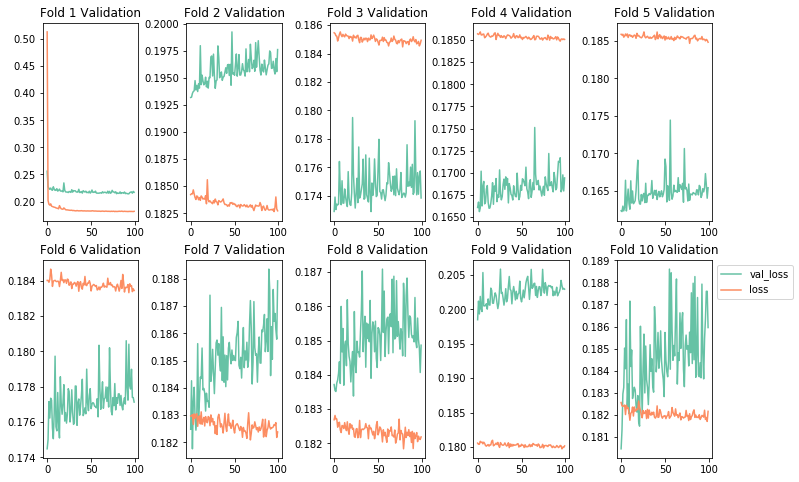

In [34]:
#Your code here; use your k-folds function to evaluate the baseline model.
import time
import datetime

now = datetime.datetime.now()

k_folds(X_train, y_train, model)

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

## Intentionally Overfitting a Model

Now that you've developed a baseline model, its time to intentionally overfit a model. To overfit a model, you can:
* Add layers
* Make the layers bigger
* Increase the number of training epochs

Again, be careful here. Think about the limitations of your resources, both in terms of your computers specs and how much time and patience you have to let the process run. Also keep in mind that you will then be regularizing these overfit models, meaning another round of experiments and more time and resources.  

For example, here are some timing notes on potential experiments run on a Macbook Pro 3.1 GHz Intel Core i5 with 16gb of RAM:

* Using our 10 fold cross validation methodology, a 5-layer neural network with 10 units per hidden layer and 100 epochs took approximately 15 minutes to train and validate  

* Using our 10 fold cross validation methodology, a 5-layer neural network with 25 units per hidden layer and 100 epochs took approximately 25 minutes to train and validate  

* Using our 10 fold cross validation methodology, a 5-layer neural network with 10 units per hidden layer and 250 epochs took approximately 45 minutes to train and validate


In [ ]:
#Your code here; try some methods to overfit your network

In [ ]:
#Your code here; try some methods to overfit your network

In [ ]:
#Your code here; try some methods to overfit your network

## Regularizing the Model to Achieve Balance  

Now that you have a powerful model (albeit an overfit one), we can now increase the generalization of the model by using some of the regularization techniques we discussed. Some options you have to try include:  
* Adding dropout
* Adding L1/L2 regularization
* Altering the layer architecture (add or remove layers similar to above)  

This process will be constrained by time and resources. Be sure to test at least 2 different methodologies, such as dropout and L2 regularization. If you have the time, feel free to continue experimenting.

Notes: 

In [36]:
#Your code here; try some regularization or other methods to tune your network
from keras import regularizers

In [ ]:
#Your code here; try some regularization or other methods to tune your network

In [ ]:
#Your code here; try some regularization or other methods to tune your network

In [ ]:
#Your code here; try some regularization or other methods to tune your network

## Final Evaluation

Now that you have selected a network architecture, tested various regularization procedures and tuned hyperparameters via a validation methodology, it is time to evaluate your finalized model once and for all. Fit the model using all of the training and validation data using the architecture and hyperparameters that were most effective in your expirements above. Afterwards, measure the overall performance on the hold-out test data which has been left untouched (and hasn't leaked any data into the modelling process)!

In [38]:
#Your code here; final model training on entire training set followed by evaluation on hold-out data
now = datetime.datetime.now()


model = Sequential()
model.add(Dense(7, input_dim=23, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

hist =  hist = model.fit(X_train, y_train, batch_size=32, epochs=75)

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

Epoch 1/75
37254/37254 [==============================] - 4s 98us/step - loss: 0.4049 - mean_squared_error: 0.2803
Epoch 2/75
37254/37254 [==============================] - 3s 87us/step - loss: 0.3054 - mean_squared_error: 0.2047
Epoch 3/75
37254/37254 [==============================] - 3s 78us/step - loss: 0.2846 - mean_squared_error: 0.2031
Epoch 4/75
37254/37254 [==============================] - 3s 79us/step - loss: 0.2689 - mean_squared_error: 0.2027
Epoch 5/75
37254/37254 [==============================] - 3s 78us/step - loss: 0.2565 - mean_squared_error: 0.2022
Epoch 6/75
37254/37254 [==============================] - 2s 67us/step - loss: 0.2475 - mean_squared_error: 0.2027
Epoch 7/75
37254/37254 [==============================] - 3s 72us/step - loss: 0.2392 - mean_squared_error: 0.2019
Epoch 8/75
37254/37254 [==============================] - 3s 77us/step - loss: 0.2329 - mean_squared_error: 0.2015
Epoch 9/75
37254/37254 [==============================] - 3s 79us/step - loss: 0

37254/37254 [==============================] - 3s 71us/step - loss: 0.1987 - mean_squared_error: 0.1919
Epoch 72/75
37254/37254 [==============================] - 2s 54us/step - loss: 0.1990 - mean_squared_error: 0.1921
Epoch 73/75
37254/37254 [==============================] - 2s 66us/step - loss: 0.1991 - mean_squared_error: 0.1923
Epoch 74/75
37254/37254 [==============================] - 3s 71us/step - loss: 0.1991 - mean_squared_error: 0.1923
Epoch 75/75
37254/37254 [==============================] - 2s 66us/step - loss: 0.1988 - mean_squared_error: 0.1921
Time Elapsed: 0:03:19.766801


In [39]:
    model.evaluate(X_test, y_test)

4140/4140 [==============================] - 0s 69us/step


[0.19453463839448015, 0.1880373060559305]

## Additional Resources

https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/

https://stackoverflow.com/questions/37232782/nan-loss-when-training-regression-network
https://www.springboard.com/blog/free-public-data-sets-data-science-project/

## Summary

In this lab, we investigated some data from *The Lending Club* in a complete data science pipeline regarding neural networks. We began with reserving a hold-out set for testing which never was touched during the modeling phase. From there, we implemented a k-fold cross validation methodology in order to assess an initial baseline model and various regularization methods. From here, we'll begin to investigate other neural network architectures such as CNNs.